In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

df = pd.read_csv('Paitients_Files_Train - Paitients_Files_Train.csv')

In [11]:
df.head()

ID  PRG           PL           PR        SK         TS        M11  \
0  ICU200010  6.0  148.00 mu U  72.00 mm Hg  35.00 mm    0.00 ml  33.60 BMI   
1  ICU200011  1.0   85.00 mu U  66.00 mm Hg  29.00 mm    0.00 ml  26.60 BMI   
2  ICU200012  8.0  183.00 mu U  64.00 mm Hg   0.00 mm    0.00 ml  23.30 BMI   
3  ICU200013  1.0   89.00 mu U  66.00 mm Hg  23.00 mm   94.00 ml  28.10 BMI   
4  ICU200014  0.0  137.00 mu U  40.00 mm Hg  35.00 mm  168.00 ml  43.10 BMI   

         BD2  Age  Insurance   Sepssis  
0  0.63 mu U   50          0  Positive  
1  0.35 mu U   31          0  Negative  
2  0.67 mu U   32          1  Positive  
3  0.17 mu U   21          1  Negative  
4  2.29 mu U   33          1  Positive

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    float64
 2   PL         599 non-null    object 
 3   PR         599 non-null    object 
 4   SK         599 non-null    object 
 5   TS         599 non-null    object 
 6   M11        599 non-null    object 
 7   BD2        599 non-null    object 
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.6+ KB


In [15]:
# Clean up data values by removing labels from vital columns
# and encoding Sepssis column

le = LabelEncoder()
df['ID'] = df['ID'].str.replace(r'^ICU', '', regex=True)
df['PL'] = df['PL'].str.replace(r'\smu U', '', regex=True)
df['PR'] = df['PR'].str.replace(r'\smm Hg', '', regex=True)
df['SK'] = df['SK'].str.replace(r'\smm', '', regex=True)
df['TS'] = df['TS'].str.replace(r'\sml', '', regex=True)
df['M11'] = df['M11'].str.replace(r'\sBMI', '', regex=True)
df['BD2'] = df['BD2'].str.replace(r'\smu U', '', regex=True)
df['Sepssis_encoded'] = le.fit_transform(df['Sepssis'])

# Assign numerical values from strings in temp dataframe
df_temp = df.drop(columns=['Sepssis', 'ID', 'PRG'], axis=1)
df_temp = df_temp.apply(lambda x: pd.to_numeric(x), axis=0)


In [17]:
# Check for NaN values

df_temp.isna().any().any()

False

In [19]:
# Check for null values

df_temp.isnull().values.any()

False

In [21]:
# What are the new data types

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PL               599 non-null    float64
 1   PR               599 non-null    float64
 2   SK               599 non-null    float64
 3   TS               599 non-null    float64
 4   M11              599 non-null    float64
 5   BD2              599 non-null    float64
 6   Age              599 non-null    int64  
 7   Insurance        599 non-null    int64  
 8   Sepssis_encoded  599 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 42.2 KB


In [23]:
# Create training and testing data set from df_temp and df dataframe
# Grab column names
column_names = df_temp.columns

# Scale the feeatures
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(df_temp)
df_temp = pd.DataFrame(scaler.fit_transform(df_temp), columns=column_names)
X = df_temp.drop(columns=['Sepssis_encoded'], axis=1)

# Sepssis is a binary value, no scaling needed
y = df['Sepssis_encoded']

# Create training and testing data
X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# define the models to do a GridSearch over

clfs = [LinearRegression(),
        KNeighborsRegressor(), 
        DecisionTreeRegressor(), 
        Ridge(), 
        SVR()]

# define the parameters to search over
# this took a few guess and check runs 
# to settle on 

param_grids = {'linear': {},
               'knn': {'n_neighbors': [23, 24, 25]},
               'tree': {'max_depth': [1, 2, 3]},
               'ridge': {'alpha': [0.1, 1, 2, 3, 4]},
               'svr':  {'kernel' : ('linear', 'rbf', 'sigmoid'),
                        'C' : [0.1, 0.5, 1.0, 1.5, 2.0],
                        'degree' : [1, 3, 5, 7],
                        'coef0' : [0.0001, 0.001, 0.01],
                        'gamma' : ('auto','scale')}
              }

# store test/predicted mse errors in a dictionary

results_mseerror_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store best_score_ in a dictionary

results_bestscore_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store accuracy in a dictionary

results_accuracy_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store best parameters from GridSearch in a dictionary

best_params_grid = {'linear': [],
                    'knn': [],
                    'decision': [],
                    'ridge': [],
                    'svr': []
                   }

k = 0

# do a GridSearch using the different models and parameter grids

for model, name in zip(clfs, ['linear', 'knn', 'tree', 'ridge', 'svr']):
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_Train, y_train)
    best_pipeline = grid_search.best_estimator_
    best_score = grid_search.best_score_
    y_pred = best_pipeline.predict(X_Test)
    y_pred_class = np.where(y_pred >= 0.5, 1,0)
    results_mseerror_grid[list(results_mseerror_grid.keys())[k]] = mean_squared_error(y_test, y_pred_class)
    results_bestscore_grid[list(results_bestscore_grid.keys())[k]] = best_score
    results_accuracy_grid[list(results_accuracy_grid.keys())[k]] = accuracy_score(y_test, y_pred_class)
    best_params_grid[list(best_params_grid.keys())[k]] = grid_search.best_params_
    k += 1


In [26]:
results_mseerror_grid

{'linear': 0.2388888888888889,
 'knn': 0.3333333333333333,
 'decision': 0.28888888888888886,
 'ridge': 0.2611111111111111,
 'svr': 0.25}

In [29]:
results_accuracy_grid

{'linear': 0.7611111111111111,
 'knn': 0.6666666666666666,
 'decision': 0.7111111111111111,
 'ridge': 0.7388888888888889,
 'svr': 0.75}

In [31]:
results_bestscore_grid

{'linear': -0.16119210778470738,
 'knn': -0.16876902451074138,
 'decision': -0.163637728632874,
 'ridge': -0.16068009000001543,
 'svr': -0.16329726451730922}

In [33]:
best_params_grid

{'linear': {},
 'knn': {'n_neighbors': 24},
 'decision': {'max_depth': 2},
 'ridge': {'alpha': 1},
 'svr': {'C': 0.5,
  'coef0': 0.0001,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'rbf'}}

In [35]:
# Coefficients from Ridge regression
# had the lowest MSE using 
# values from best run

ridge_reg = Ridge(alpha = 1)
ridge_reg.fit(X_Train, y_train)
coefficients_ridge = ridge_reg.coef_
coefficients_ridge_df = pd.DataFrame({'feature': X_Train.columns, 'coefficient': coefficients_ridge})
coefficients_ridge_df = coefficients_ridge_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Ridge Regression:")
print(coefficients_ridge_df)


Coefficients from Ridge Regression:
     feature  coefficient
0         PL     1.018130
4        M11     0.990655
5        BD2     0.367955
6        Age     0.204976
7  Insurance     0.072684
3         TS     0.068662
2         SK    -0.032800
1         PR    -0.180991


In [37]:
# Coefficients from Linear regression

linear_reg = LinearRegression()
linear_reg.fit(X_Train, y_train)
coefficients_linear = linear_reg.coef_
coefficients_linear_df = pd.DataFrame({'feature': X_Train.columns, 'coefficient': coefficients_linear})
coefficients_linear_df = coefficients_linear_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Linear Regression:")
print(coefficients_linear_df)


Coefficients from Linear Regression:
     feature  coefficient
4        M11     1.209178
0         PL     1.098425
5        BD2     0.382251
6        Age     0.200655
7  Insurance     0.068691
3         TS     0.039529
2         SK    -0.075161
1         PR    -0.229274


In [39]:
# Feature importance using permutation for KNN
# using values from best run

best_knn = KNeighborsRegressor(n_neighbors = 24) 
best_knn.fit(X_Train, y_train)
result_knn = permutation_importance(best_knn, X_Test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_Test.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN:")
print(perm_importances_knn)


Permutation Importance from KNN:
     feature  importance
0         PL    0.180248
6        Age    0.060548
4        M11    0.049600
7  Insurance    0.014462
2         SK    0.010151
1         PR    0.010097
5        BD2    0.003771
3         TS    0.000274


In [40]:
# Feature importance using permutation for SVR
# using values from best run

best_svr = SVR(C = 0.5, coef0 = 0.0001, degree = 1, gamma = 'auto', kernel = 'linear')
best_svr.fit(X_Train, y_train)
result_svr = permutation_importance(best_svr, X_Test, y_test, random_state=42)
perm_importances_svr = pd.DataFrame({'feature': X_Test.columns, 'importance': result_svr.importances_mean})
perm_importances_svr = perm_importances_svr.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVR:")
print(perm_importances_svr)


Permutation Importance from SVR:
     feature  importance
0         PL    0.303453
4        M11    0.121438
1         PR    0.025345
6        Age    0.019182
5        BD2    0.005347
2         SK    0.004170
7  Insurance   -0.000478
3         TS   -0.019115


In [43]:
# Feature importance from Decision Tree
# using values from best run

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(X_Train, y_train)
importances_tree = tree_reg.feature_importances_
feature_importance_tree_df = pd.DataFrame({'feature': X_Train.columns, 'importance': importances_tree})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)


Feature Importance from Decision Tree:
     feature  importance
0         PL    0.894542
4        M11    0.105458
1         PR    0.000000
2         SK    0.000000
3         TS    0.000000
5        BD2    0.000000
6        Age    0.000000
7  Insurance    0.000000


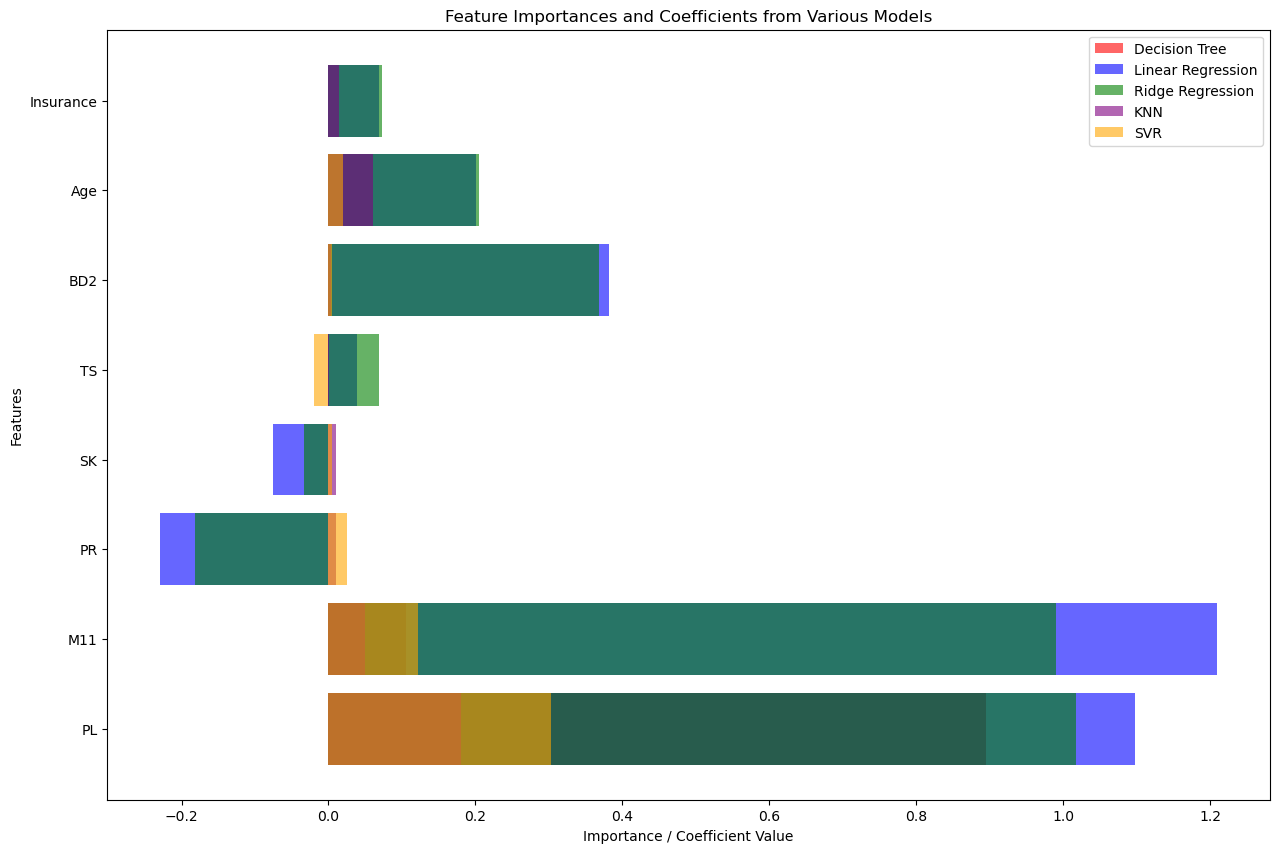

In [45]:
# Plotting the feature importances and coefficients
plt.figure(figsize=(15, 10))

# Plot Decision Tree feature importance
plt.barh(feature_importance_tree_df['feature'], feature_importance_tree_df['importance'], color='red', alpha=0.6, label='Decision Tree')

# Plot Linear Regression coefficients
plt.barh(coefficients_linear_df['feature'], coefficients_linear_df['coefficient'], color='blue', alpha=0.6, label='Linear Regression')

# Plot Ridge Regression coefficients
plt.barh(coefficients_ridge_df['feature'], coefficients_ridge_df['coefficient'], color='green', alpha=0.6, label='Ridge Regression')

# Plot KNN permutation importance
plt.barh(perm_importances_knn['feature'], perm_importances_knn['importance'], color='purple', alpha=0.6, label='KNN')

# Plot SVR permutation importance
plt.barh(perm_importances_svr['feature'], perm_importances_svr['importance'], color='orange', alpha=0.6, label='SVR')

plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Various Models')
plt.legend()
plt.show()

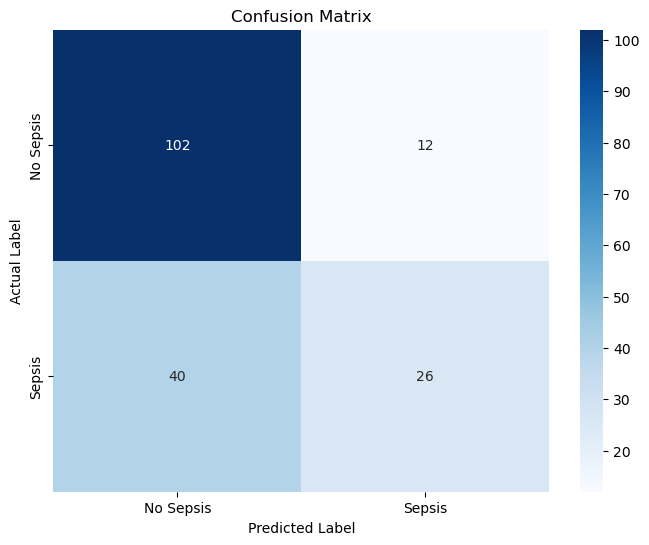

[[102  12]
 [ 40  26]]


In [47]:
# Sample actual and predicted labels
y_test
predicted = best_svr.predict(X_Test)
predicted_class = np.where(predicted >= 0.5, 1,0)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)

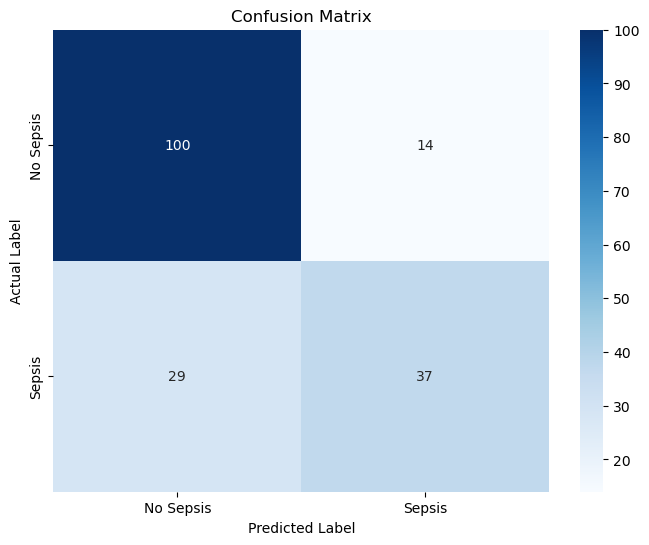

[[100  14]
 [ 29  37]]


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Sample actual and predicted labels
y_test
predicted = linear_reg.predict(X_Test)
predicted_class = np.where(predicted >= 0.5, 1,0)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)